# The goal is to generate a function `dist_from_centroid`

## The function will accept surface `vertices` and the centroid of a cell `centroid`
### We will then calculate the distnace using spherical coordinates and plot this on the cell surface

In [ ]:
from chimerax.color_key import show_key
from chimerax.core import colors
from chimerax.core.commands import (BoolArg, Bounded, CmdDesc, ColormapArg,
                                    ColormapRangeArg, Int2Arg, IntArg,
                                    SurfacesArg)
from chimerax.core.commands.cli import EnumOf
from chimerax.surface import (surface_area, vertex_convexity)
from chimerax.map.volumecommand import volume
from numpy import (arccos, array, full, inf, isnan, mean, nan, nanmax, nanmean,
                   nanmin, pi, ravel_multi_index, sign, split, sqrt, subtract,
                   swapaxes, savetxt, column_stack,nansum, count_nonzero, nanstd)
from scipy.ndimage import (binary_dilation, binary_erosion,
                           generate_binary_structure, iterate_structure)
from scipy.spatial import KDTree

In [ ]:
s= session
m= s.models
import numpy.pi as pi

In [ ]:
radius= 8
metric='RPD'
target ='sRBC'
size=(.1208,.1208,.1208)
palette=None
color_range= None
key=False
volume(session, voxel_size= size)

In [ ]:
if target == 'sRBC':
        target_r = 2.25
    elif target =='mRBC':
        target_r = 3

In [ ]:
    """Define the target centroid from mid range x,y and z coordinates."""
    centroid = mean(to_cell.vertices, axis=0)

    """Vertice x,y and z distances from centroid"""
    x_coord, y_coord, z_coord = split(subtract(surface.vertices, centroid), 3, 1)

    x_coord = x_coord.flatten()
    y_coord = y_coord.flatten()
    z_coord = z_coord.flatten()
    """Converting the cartisian system into spherical coordinates"""
    z_squared = z_coord ** 2
    y_squared = y_coord ** 2
    x_squared = x_coord ** 2
    
    distance = sqrt(z_squared + y_squared + x_squared)
    distxy = sqrt(x_squared + y_squared)
    theta = sign(y_coord)*arccos(x_coord / distxy)
    phi = arccos(z_coord / distance)

    """Logic to identify vertices in the targets local (defined by radius input) around target's upper hemisphere"""
    abovePhi = phi <= (pi/2)
    radialClose = (distance  < radius) & (distance > target_r)

    """Outputs for coloring vertices as surface. arguments"""
    radialDistanceAbovePhiLimitxy = abovePhi * radialClose * distance
    surface.radialDistanceAbovePhiNoNans= abovePhi * radialClose * distance 
    radialDistanceAbovePhiLimitxy[radialDistanceAbovePhiLimitxy == 0] = nan

    surface.radialDistanceAbovePhi= abovePhi* distance
    surface.radialDistanceAbovePhiLimitxy=radialDistanceAbovePhiLimitxy

    surface.radialDistance = distance
    surface.theta = theta
    surface.phi = phi

In [ ]:
    """Logic to identify vertices in the targets local (defined by radius input) around target's upper hemisphere"""
    abovePhi = phi <= (pi/2)
    radialClose = (distance  < radius) & (distance > target_r)

    """Single value outputs for definning topology"""
    surface.IRDFCarray = nanmean(radialDistanceAbovePhiLimitxy)
    surface.Sum = nansum(radialDistanceAbovePhiLimitxy)
    """ surface.area = surface_area(vertices, triangles) """

    surface.area = count_nonzero(surface.radialDistanceAbovePhiNoNans)
    surface.ArealRoughness = sqrt(surface.IRDFCarray**2/(2*pi*target_r**2))
    surface.ArealRoughness_STD = nanstd(surface.radialDistanceAbovePhiLimitxy)/(2*pi*target_r**2)

In [ ]:
    if metric == 'distance' and hasattr(surface, 'distance'):
        measurement = surface.distance
        palette_string = 'brbg'
        max_range = 15
    elif metric == 'intensity' and hasattr(surface, 'intensity'):
        measurement = surface.intensity
        palette_string = 'purples'
        max_range = 5
    elif metric == 'R' and hasattr(surface, 'radialDistance'):
        measurement = surface.radialDistance
        palette_string = 'purples'
        max_range = 100
    elif metric == 'Rphi' and hasattr(surface, 'radialDistanceAbovePhi'):
        measurement = surface.radialDistanceAbovePhi
        palette_string = 'purples'
        max_range = 10
    elif metric == 'rpg' and hasattr(surface, 'radialDistanceAbovePhiLimitxy'):
        measurement = surface.radialDistanceAbovePhiLimitxy
        palette_string = 'purples'
        max_range = 10
    elif metric == 'rpd' and hasattr(surface, 'radialDistanceAbovePhiNoNans'):
        measurement = surface.radialDistanceAbovePhiNoNans
        palette_string = 'purples'
        max_range = 10
    elif metric == 'theta' and hasattr(surface, 'theta'):
        measurement = surface.theta
        palette_string = 'brbg'
        if color_range is None:
            color_range = -pi,pi
    elif metric == 'phi' and hasattr(surface, 'phi'):
        measurement = surface.phi
        palette_string = 'brbg'
        max_range = pi

In [ ]:
    if isnan(measurement).all():
        measurement[:] = 0

    if palette is None:
        palette = colors.BuiltinColormaps[palette_string]

    if color_range is not None and color_range != 'full':
        rmin, rmax = color_range
    elif color_range == 'full':
        rmin, rmax = nanmin(measurement), nanmax(measurement)
    else:
        rmin, rmax = (0, max_range)

In [ ]:
    cmap = palette.rescale_range(rmin, rmax)
    surface.vertex_colors = cmap.interpolated_rgba8(measurement)

In [ ]:
search=distxy*abovePhi*radialClose
fig= plt.figure()

ax = fig.add_subplot()

ax.scatter(theta,search)
ax.set_title('Scatter plot of points: theta, search')
ax.set_xlabel('theta')
ax.set_ylabel('search')
plt.show()

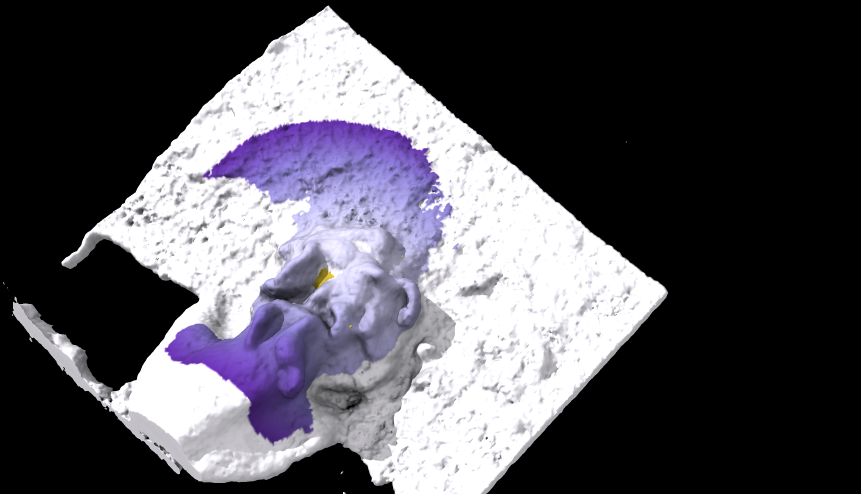

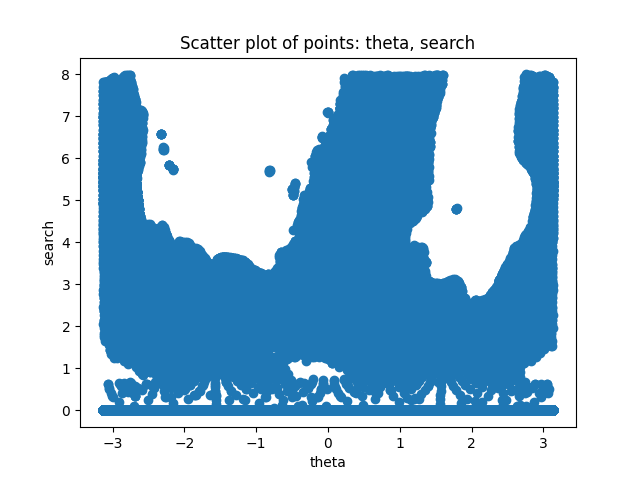